In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
from scipy.misc import imresize
import sys, time, argparse, os
import shapely.geometry
import coco_util as util

# COCO API
coco_root = '/data/datasets/coco'  # modify to point to your COCO installation
sys.path.insert(0, coco_root + '/PythonAPI')
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask

import caffe

from helpers import get_COCO_net_transformer, get_net
from defaults import caffe_dir as caffe_root
from heatmaps import compute_heatmap
from eval_coco import doExcitationBackprop

tags, tag2ID = util.loadTags(caffe_root + '/models/COCO/catName.txt')
imgScale = 224
topBlobName = 'loss3/classifier'
topLayerName = 'loss3/classifier'
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = 'pool5/7x7_s1'
outputLayerName = 'pool2/3x3_s2'
outputBlobName = 'pool2/3x3_s2'

In [2]:
imset   = 'val2014'
imgDir  = '%s/images/%s/'%(coco_root, imset)
annFile = '%s/annotations/instances_%s.json'%(coco_root, imset)
cocoAnn = COCO(annFile)
cocoAnn.info()
catIds  = cocoAnn.getCatIds()
catList = cocoAnn.loadCats(catIds)

loading annotations into memory...
Done (t=13.49s)
creating index...
index created!
description: This is stable 1.0 version of the 2014 MS COCO dataset.
url: http://mscoco.org
version: 1.0
year: 2014
contributor: Microsoft COCO group
date_created: 2015-01-27 09:11:52.357475


In [3]:
# init caffe
#caffeNet = initCaffe(args)
gpu = 0
if gpu is not None:
    caffe.set_device(gpu)
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()

caffeNet = get_net('googlenet_coco')

for layer_name, blob in caffeNet.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
transformer = get_COCO_net_transformer(caffeNet)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [4]:
def point(I, cocoAnn, cat, caffeNet, imgDir, transformer, heatmapType, topName = 'loss3/classifier', 
    bottomName = 'data', normDeg = np.inf, naiveMax = True, gpu = None, use_orig_imp = False, show_fig = False):
    # run EB on img, get max location on attMap
    imgName = os.path.join(imgDir, I['file_name'])
    img     = caffe.io.load_image(imgName)
    if heatmapType != 'center':
        if heatmapType == 'contrast_excitation_backprop' and use_orig_imp:
            print 'aa'
            (attMap, _)  = doExcitationBackprop(caffeNet, img, cat['name'])
        else:
            print 'bb'
            (attMap, _) = compute_heatmap(net = caffeNet, transformer = transformer, paths = imgName, labels = cat['id']-1,
                               heatmap_type = heatmapType, topBlobName = topName, topLayerName = topName,
                               outputBlobName = bottomName, outputLayerName = bottomName, norm_deg = normDeg,
                               gpu = gpu)

        # reshape to original image
        print img.shape
        attMap = transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'nearest')
        plot_heatmap(attMap)

        if naiveMax:
            # naively take argmax
            maxSub = np.unravel_index(np.argmax(attMap), attMap.shape)
        else:
            # take center of max locations
            maxAtt = np.max(attMap)
            maxInd = np.where(attMap == maxAtt)
            maxSub = (np.mean(maxInd[0]), np.mean(maxInd[1]))
    else:
        # choose center of image
        maxSub = (img.shape[0]/float(2), img.shape[1]/float(2))

    # determine if it's a difficult image (1) sum of the area of bounding boxes is less than 1/4 of image area,
    # 2) at least one distractor category
    allAnnList = cocoAnn.loadAnns(cocoAnn.getAnnIds(imgIds=I['id']))
    bbsArea = np.sum([a['area'] for a in allAnnList])
    imgArea = np.prod(img.shape[:2])
    numCats = len(np.unique([a['category_id'] for a in allAnnList]))
    isDiff  = bbsArea < 0.25*imgArea and numCats > 1

    # load annotations (for target category)
    annList = cocoAnn.loadAnns(cocoAnn.getAnnIds(imgIds=I['id'], catIds=cat['id']))

    # hit/miss?
    isHit = 0
    for ann in annList:
        # create a radius-15 circle around max location and see if it 
        # intersects with segmentation mask
        if type(ann['segmentation']) == list:
            # polygon
            for seg in ann['segmentation']:
                polyPts = np.array(seg).reshape((len(seg)/2, 2))
                poly    = shapely.geometry.Polygon(polyPts)
                circ    = shapely.geometry.Point(maxSub[::-1]).buffer(15)
                isHit  += poly.intersects(circ)
        else:
            # RLE
            if type(ann['segmentation']['counts']) == list:
                rle = mask.frPyObjects([ann['segmentation']], I['height'], I['width'])
            else:
                rle = [ann['segmentation']]
            m = mask.decode(rle)
            m = m[:, :, 0]
            ind  = np.where(m>0)
            mp   = shapely.geometry.MultiPoint(zip(ind[0], ind[1]))
            circ = shapely.geometry.Point(maxSub).buffer(15)
            isHit += circ.intersects(mp)

        if isHit:
            break
            
    if show_fig:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        if heatmapType != 'center':
            ax.imshow(attMap, alpha=0.5, cmap='jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_artist(plt.Circle((maxSub[1], maxSub[0]), 5, color='r'))
        plt.show()
    #rect = patches.Rectangle((bb_coords[0],bb_coords[1]),bb_coords[2]-bb_coords[0],bb_coords[3]-bb_coords[1],
    #             linewidth=1,edgecolor= 'g' if is_hit else 'r',facecolor='none')
    #ax[1].add_patch(rect)
        
    print cat['name'], isHit, isDiff
    return isHit, isDiff

In [5]:
def plot_heatmap(attMap, img = None):
    f, ax = plt.subplots(1,1)
    if img is not None:
        ax.imshow(img)
        ax.imshow(attMap, alpha=0.5, cmap='jet')
    else:
        ax.imshow(attMap, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.add_artist(plt.Circle((maxSub[1], maxSub[0]), 5, color='r'))
    plt.show()

In [15]:
# set heatmap type and parameters
heatmapType = 'guided_backprop'

if heatmapType == 'excitation_backprop':
    normDeg = -1
    bottomName = 'pool2/3x3_s2'
elif heatmapType == 'contrast_excitation_backprop':
    normDeg = -2
    bottomName = 'pool2/3x3_s2'
else:
    normDeg = np.inf
    bottomName = 'data'

naiveMax = True

{u'supercategory': u'vehicle', u'id': 3, u'name': u'car'}
(224, 224)


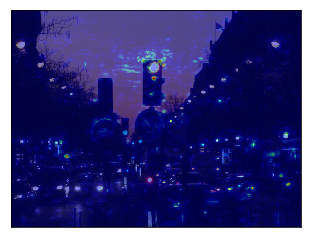

In [16]:
cat = catList[2] # person
print cat

imgIds  = cocoAnn.getImgIds(catIds=cat['id'])
imgList = cocoAnn.loadImgs(ids=imgIds)


I = imgList[1]
transformer = get_COCO_net_transformer(caffeNet)

# run EB on img, get max location on attMap
imgName = os.path.join(imgDir, I['file_name'])
img     = caffe.io.load_image(imgName)
attMap = compute_heatmap(net = caffeNet, transformer = transformer, paths = imgName, labels = cat['id']-1,
                   heatmap_type = heatmapType, topBlobName = topBlobName, topLayerName = topLayerName,
                   outputBlobName = bottomName, outputLayerName = bottomName, norm_deg = normDeg,
                   gpu = gpu)
print attMap.shape
plot_heatmap(imresize(attMap, img.shape[:2]), img)


In [7]:
cat = catList[2] # person
imgIds  = cocoAnn.getImgIds(catIds=cat['id'])
imgList = cocoAnn.loadImgs(ids=imgIds)

I = imgList[1]
transformer = get_COCO_net_transformer(caffeNet)
is_hit, is_diff = point(I, cocoAnn, cat, caffeNet, imgDir, transformer, heatmapType, topName = 'loss3/classifier', 
    bottomName = bottomName, normDeg = -2, naiveMax = True, gpu = gpu, use_orig_imp = False, show_fig = True)
print is_hit, is_diff

bb


NameError: global name 'outLayerName' is not defined

In [10]:
try:
    list(caffeNet._layer_names).index('data')

ValueError: 'data' is not in list

In [9]:
maxImgs = 400
num_per_cat = []
totImgList = []
for i in range(len(catList)):
    cat = catList[i]
    imgIds  = cocoAnn.getImgIds(catIds=cat['id'])
    imgList = cocoAnn.loadImgs(ids=imgIds)
    numImgs = np.minimum(len(imgList), maxImgs).astype(int)
    num_per_cat.append(numImgs)
    totImgList.extend(imgList[:numImgs])
    print i+1, cat['name'], cat['id'], len(imgList)
print np.mean(num_per_cat), np.sum(num_per_cat), len(np.unique(totImgList))

1 person 1 21634
2 bicycle 2 1114
3 car 3 4180
4 motorcycle 4 1219
5 airplane 5 840
6 bus 6 1350
7 train 7 1281
8 truck 8 2056
9 boat 9 1048
10 traffic light 10 1437
11 fire hydrant 11 592
12 stop sign 13 589
13 parking meter 14 261
14 bench 15 1961
15 bird 16 1121
16 cat 17 1480
17 dog 18 1521
18 horse 19 1001
19 sheep 20 489
20 cow 21 666
21 elephant 22 714
22 bear 23 341
23 zebra 24 677
24 giraffe 25 849
25 backpack 27 1832
26 umbrella 28 1393
27 handbag 31 2272
28 tie 32 1288
29 suitcase 33 876
30 frisbee 34 757
31 skis 35 993
32 snowboard 36 533
33 sports ball 37 1445
34 kite 38 727
35 baseball bat 39 799
36 baseball glove 40 845
37 skateboard 41 1092
38 surfboard 42 1292
39 tennis racket 43 1193
40 bottle 44 2912
41 wine glass 46 872
42 cup 47 3061
43 fork 48 1173
44 knife 49 1410
45 spoon 50 1189
46 bowl 51 2397
47 banana 52 728
48 apple 53 491
49 sandwich 54 818
50 orange 55 568
51 broccoli 56 670
52 carrot 57 578
53 hot dog 58 452
54 pizza 59 1117
55 donut 60 523
56 cake 61 96

In [117]:
print len(catList)

80


In [19]:
cat = catList[0] # person
imgIds  = cocoAnn.getImgIds(catIds=cat['id'])
imgList = cocoAnn.loadImgs(ids=imgIds)

hits = 0
miss = 0
diff_hits = 0
diff_miss = 0
for i in range(10):
    I = imgList[i]
    print I
    transformer = get_COCO_net_transformer(caffeNet)
    is_hit, is_diff = point(I, cocoAnn, cat, caffeNet, imgDir, transformer, heatmapType, topName = 'loss3/classifier', 
        bottomName = bottomName, normDeg = np.inf, naiveMax = True, gpu = None, show_fig = True)
    if is_hit:
        hits += 1
    else:
        miss += 1
    if is_diff:
        if is_hit:
            diff_hits += 1
        else:
            diff_miss += 1
    print np.true_divide(hits, hits+miss), np.true_divide(diff_hits, diff_hits + diff_miss)
    
    _, _ = point(I, cocoAnn, cat, caffeNet, imgDir, transformer, heatmapType, topName = 'loss3/classifier', 
        bottomName = bottomName, normDeg = np.inf, naiveMax = True, gpu = None, use_orig_imp = True, show_fig = True)

{u'license': 2, u'file_name': u'COCO_val2014_000000328430.jpg', u'coco_url': u'http://mscoco.org/images/328430', u'height': 640, u'width': 433, u'date_captured': u'2013-11-23 03:20:55', u'flickr_url': u'http://farm3.staticflickr.com/2412/3588308808_4642ce68eb_z.jpg', u'id': 328430}
bb


ValueError: too many values to unpack